In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Create output directory if it doesn't exist
output_dir = 'model_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)



In [ ]:
# For this example, we'll use a synthetic dataset
# In a real project, you would load your own dataset
from sklearn.datasets import make_classification

# Generate a synthetic dataset for demonstration
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5,
                          n_redundant=2, n_classes=2, random_state=42)

# Convert to pandas DataFrame for better handling
feature_names = [f'feature_{i+1}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Display the first few rows of the dataset
print("Dataset Preview:")
print(df.head())

# Basic data exploration
print("\nDataset Information:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nClass Distribution:")
print(df['target'].value_counts())



Dataset Preview:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   1.125100   1.178124   0.493516   0.790880  -0.614278   1.347020   
1  -0.564641   3.638629  -1.522415  -1.541705   1.616697   4.781310   
2   0.516313   2.165426  -0.628486  -0.386923   0.492518   1.442381   
3   0.537282   0.966618  -0.115420   0.670755  -0.958516   0.871440   
4   0.278385   1.065828  -1.724917  -2.235667   0.715107   0.731249   

   feature_7  feature_8  feature_9  feature_10  target  
0   1.419515   1.357325   0.966041   -1.981139       1  
1   3.190292  -0.890254   1.438826   -3.828748       0  
2   1.332905  -1.958175  -0.348803   -1.804124       0  
3   0.508186  -1.034471  -1.654176   -1.910503       1  
4  -0.674119   0.598330  -0.524283    1.047610       0  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0  

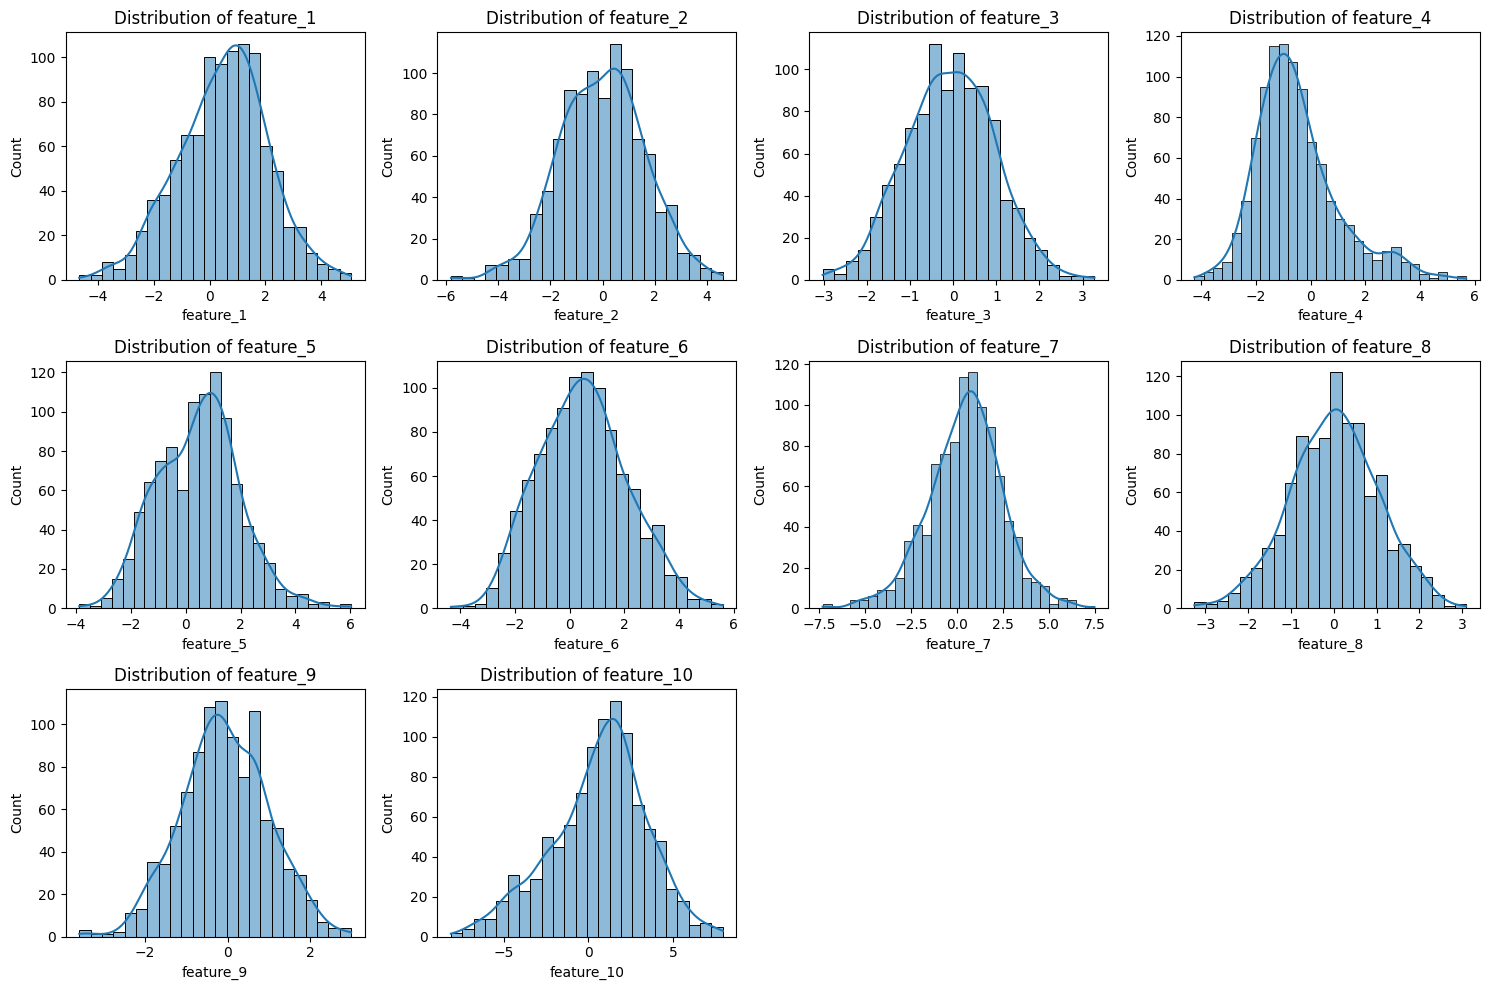

In [ ]:
# Visualize the distribution of features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_distributions.png'))

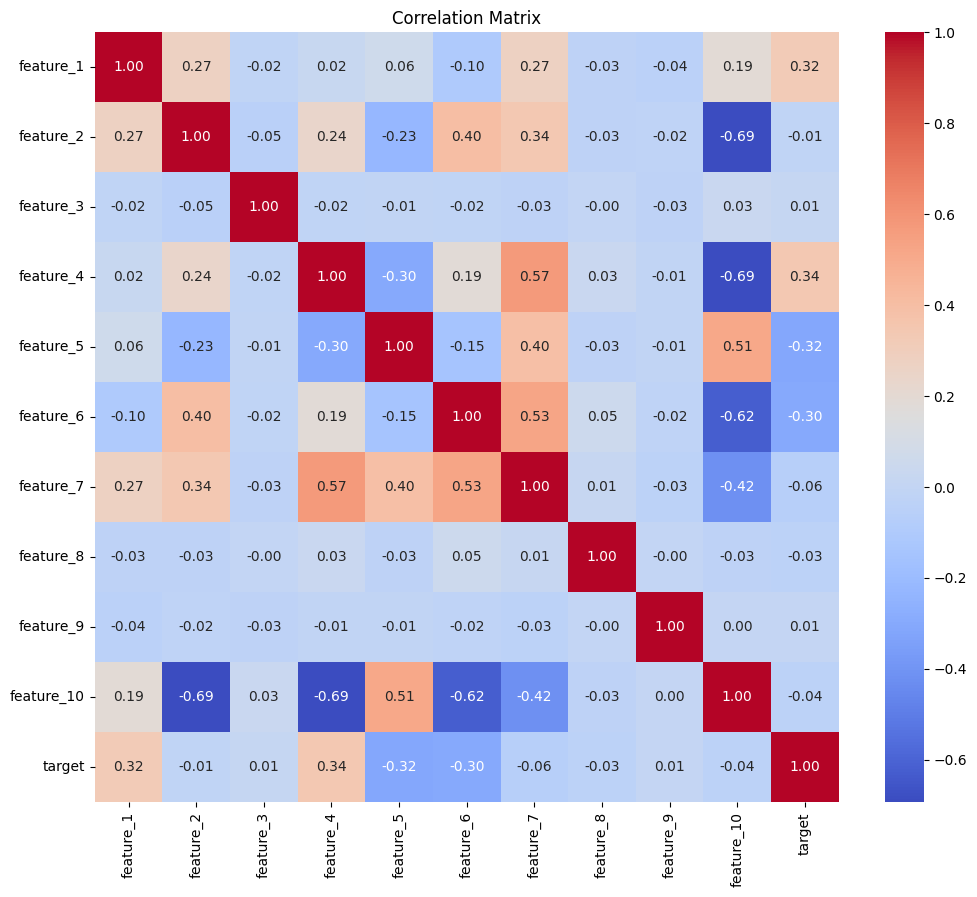

In [ ]:
# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'))

In [ ]:
# Prepare data for modeling

# Define features and target
X = df.drop('target', axis=1)
y = df['target']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (800, 10)
Testing set shape: (200, 10)


In [ ]:
# Save the test data for later use in the dashboard
test_data = {
    'X_test': X_test,
    'y_test': y_test,
    'feature_names': feature_names
}
with open(os.path.join(output_dir, 'test_data.pkl'), 'wb') as f:
    pickle.dump(test_data, f)


In [ ]:
# Create preprocessing pipeline
# For this synthetic data, we'll just use standard scaling
# In a real project, you would need to handle categorical features and missing values
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [ ]:
# Define the models we'll use
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [ ]:
# Function to train and evaluate models
def train_evaluate_model(model, X_train, X_test, y_train, y_test, preprocessor=None):
    if preprocessor:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Return all metrics and predictions
    return {
        'model': model.__class__.__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

In [ ]:
# Train and evaluate all models
model_results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    results = train_evaluate_model(model, X_train, X_test, y_train, y_test, preprocessor)
    model_results[name] = results
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")


Training Logistic Regression...
Accuracy: 0.8550
Precision: 0.8913
Recall: 0.8119
F1 Score: 0.8497

Training Decision Tree...
Accuracy: 0.9050
Precision: 0.9271
Recall: 0.8812
F1 Score: 0.9036

Training Random Forest...
Accuracy: 0.9500
Precision: 0.9505
Recall: 0.9505
F1 Score: 0.9505

Training SVM...
Accuracy: 0.9200
Precision: 0.9381
Recall: 0.9010
F1 Score: 0.9192

Training Gradient Boosting...
Accuracy: 0.9400
Precision: 0.9588
Recall: 0.9208
F1 Score: 0.9394


In [ ]:
# Create a DataFrame with all results for easy comparison
results_df = pd.DataFrame({
    name: {
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1 Score': results['f1_score']
    } for name, results in model_results.items()
}).T

print("\nModel Performance Comparison:")
print(results_df)



# Save the initial results
results_df.to_csv(os.path.join(output_dir, 'initial_model_results.csv'))


Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression     0.855   0.891304  0.811881  0.849741
Decision Tree           0.905   0.927083  0.881188  0.903553
Random Forest           0.950   0.950495  0.950495  0.950495
SVM                     0.920   0.938144  0.900990  0.919192
Gradient Boosting       0.940   0.958763  0.920792  0.939394


<Figure size 1200x800 with 0 Axes>

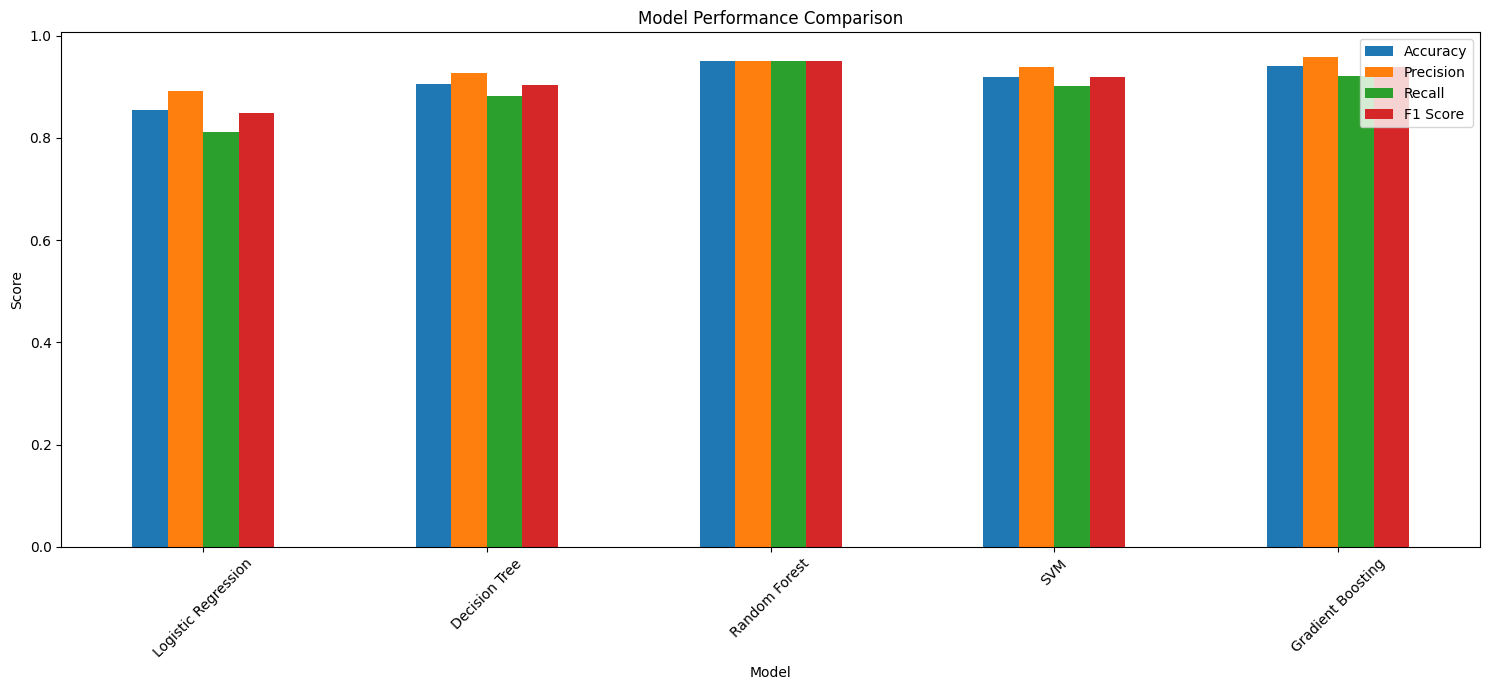

In [ ]:
# Visualize model performance
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(15, 7))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'initial_model_performance.png'))

In [ ]:
# Hyperparameter tuning for each model
# We'll use RandomizedSearchCV for efficiency

# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {
        'model__C': np.logspace(-4, 4, 10),
        'model__solver': ['lbfgs', 'liblinear'],
        'model__penalty': ['l2']
    },
    'Decision Tree': {
        'model__max_depth': [None, 5, 10, 15, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_features': ['sqrt', 'log2'],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'model__kernel': ['rbf', 'linear']
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
}

In [ ]:
# Tune hyperparameters for each model
tuned_models = {}
tuned_results = {}

print("\nHyperparameter Tuning:")
for name, model in models.items():
    print(f"\nTuning {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

    # Using RandomizedSearchCV for efficiency
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grids[name],
        n_iter=10,  # Number of parameter settings sampled
        cv=5,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    tuned_models[name] = best_model

    # Evaluate the tuned model
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tuned_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'best_params': random_search.best_params_,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")



Hyperparameter Tuning:

Tuning Logistic Regression...
Best parameters: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': np.float64(0.005994842503189409)}
Accuracy: 0.8400
Precision: 0.8710
Recall: 0.8020
F1 Score: 0.8351

Tuning Decision Tree...
Best parameters: {'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 10}
Accuracy: 0.9100
Precision: 0.9368
Recall: 0.8812
F1 Score: 0.9082

Tuning Random Forest...
Best parameters: {'model__n_estimators': 50, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 30}
Accuracy: 0.9300
Precision: 0.9307
Recall: 0.9307
F1 Score: 0.9307

Tuning SVM...
Best parameters: {'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__C': 1}
Accuracy: 0.9200
Precision: 0.9381
Recall: 0.9010
F1 Score: 0.9192

Tuning Gradient Boosting...
Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max

In [ ]:

# Create a DataFrame with tuned results for easy comparison
tuned_df = pd.DataFrame({
    name: {
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1 Score': results['f1_score']
    } for name, results in tuned_results.items()
}).T

print("\nTuned Model Performance Comparison:")
print(tuned_df)

# Save the tuned results
tuned_df.to_csv(os.path.join(output_dir, 'tuned_model_results.csv'))


Tuned Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression     0.840   0.870968  0.801980  0.835052
Decision Tree           0.910   0.936842  0.881188  0.908163
Random Forest           0.930   0.930693  0.930693  0.930693
SVM                     0.920   0.938144  0.900990  0.919192
Gradient Boosting       0.945   0.959184  0.930693  0.944724


In [ ]:
# Compare original vs tuned performance
comparison_df = pd.DataFrame({
    'Original Accuracy': [results_df.loc[name, 'Accuracy'] for name in models.keys()],
    'Tuned Accuracy': [tuned_df.loc[name, 'Accuracy'] for name in models.keys()],
    'Original F1': [results_df.loc[name, 'F1 Score'] for name in models.keys()],
    'Tuned F1': [tuned_df.loc[name, 'F1 Score'] for name in models.keys()]
}, index=models.keys())

print("\nOriginal vs Tuned Performance:")
print(comparison_df)
# Save comparison results
comparison_df.to_csv(os.path.join(output_dir, 'model_comparison.csv'))



Original vs Tuned Performance:
                     Original Accuracy  Tuned Accuracy  Original F1  Tuned F1
Logistic Regression              0.855           0.840     0.849741  0.835052
Decision Tree                    0.905           0.910     0.903553  0.908163
Random Forest                    0.950           0.930     0.950495  0.930693
SVM                              0.920           0.920     0.919192  0.919192
Gradient Boosting                0.940           0.945     0.939394  0.944724


In [ ]:

# Save the best parameters for each model
best_params_dict = {name: results['best_params'] for name, results in tuned_results.items()}
pd.DataFrame([best_params_dict]).to_csv(os.path.join(output_dir, 'best_parameters.csv'))

In [ ]:
# Extract and save feature importances for applicable models
feature_importances = {}
for name, model in tuned_models.items():
    if name in ['Random Forest', 'Decision Tree', 'Gradient Boosting']:
        if hasattr(model.named_steps['model'], 'feature_importances_'):
            importances = model.named_steps['model'].feature_importances_
            indices = np.argsort(importances)[::-1]
            feature_importance = pd.Series(importances[indices], index=np.array(feature_names)[indices])
            feature_importances[name] = feature_importance
            feature_importance.to_csv(os.path.join(output_dir, f'feature_importance_{name.replace(" ", "_").lower()}.csv'))


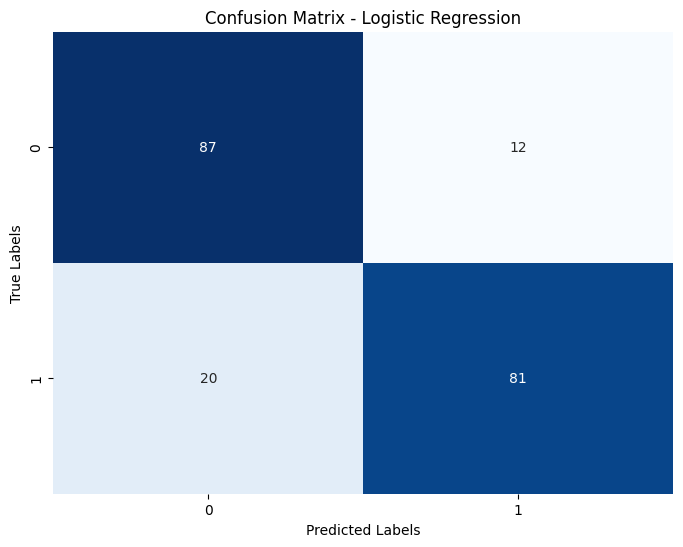

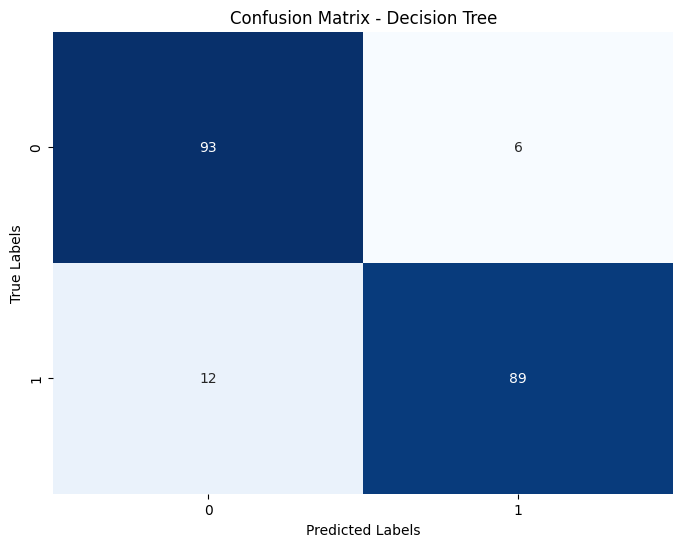

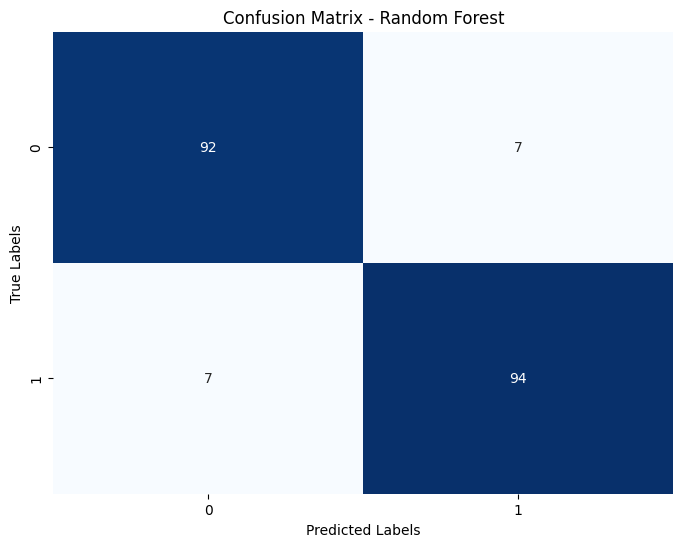

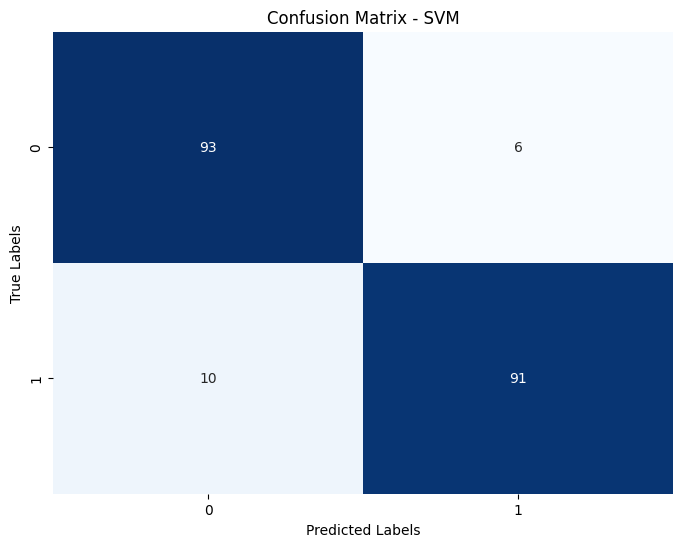

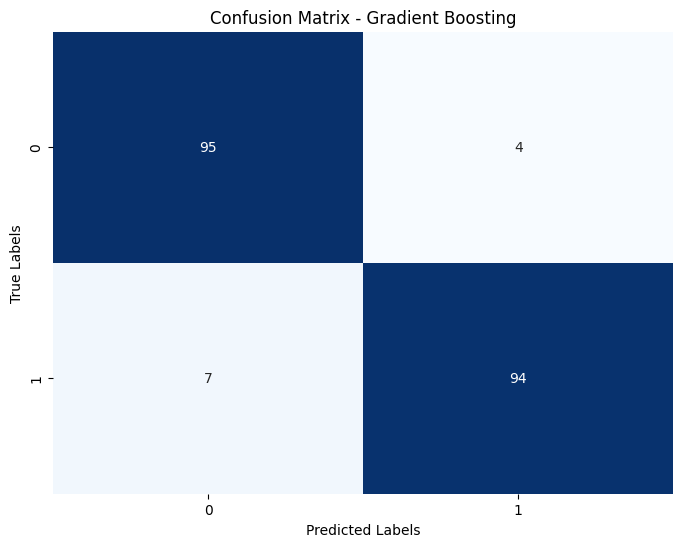

In [ ]:
# Save confusion matrices
for name, results in tuned_results.items():
    cm = confusion_matrix(y_test, results['y_pred'])
    np.savetxt(os.path.join(output_dir, f'confusion_matrix_{name.replace(" ", "_").lower()}.csv'), cm, delimiter=',', fmt='%d')

    # Also create and save a visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{name.replace(" ", "_").lower()}.png'))

In [ ]:
# Save ROC curve data
for name, results in tuned_results.items():
    if results['y_prob'] is not None:
        fpr, tpr, thresholds = roc_curve(y_test, results['y_prob'])
        roc_auc = auc(fpr, tpr)

        # Fix: Make sure all arrays have the same length
        roc_data = pd.DataFrame({
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds if len(thresholds) == len(fpr) else thresholds[:len(fpr)]
        })
        roc_data.to_csv(os.path.join(output_dir, f'roc_data_{name.replace(" ", "_").lower()}.csv'), index=False)

        # Save AUC score
        with open(os.path.join(output_dir, f'auc_{name.replace(" ", "_").lower()}.txt'), 'w') as f:
            f.write(str(roc_auc))

In [ ]:
# Save the models for later use in the dashboard
for name, model in tuned_models.items():
    with open(os.path.join(output_dir, f'model_{name.replace(" ", "_").lower()}.pkl'), 'wb') as f:
        pickle.dump(model, f)


In [ ]:
# Save model prediction results
for name, results in tuned_results.items():
    prediction_results = pd.DataFrame({
        'true_values': y_test,
        'predictions': results['y_pred']
    })
    if results['y_prob'] is not None:
        prediction_results['probability'] = results['y_prob']

    prediction_results.to_csv(os.path.join(output_dir, f'predictions_{name.replace(" ", "_").lower()}.csv'), index=False)

print("\nAll model training, evaluation, and tuning completed.")
print(f"Results and models saved to '{output_dir}' directory.")
print("You can now download these files and use them with the dashboard application.")


All model training, evaluation, and tuning completed.
Results and models saved to 'model_outputs' directory.
You can now download these files and use them with the dashboard application.


In [ ]:
# This script helps you download all the model files from Google Colab
import os
import shutil
from google.colab import files

# Define the directory where model outputs are stored
output_dir = 'model_outputs'

# Check if the directory exists
if not os.path.exists(output_dir):
    print(f"Error: Directory '{output_dir}' does not exist. Run train_models.py first.")
else:
    # Create a zip file of all model outputs
    zip_filename = 'model_outputs.zip'

    print(f"Creating zip file of all model outputs: {zip_filename}")
    shutil.make_archive('model_outputs', 'zip', output_dir)

    # Download the zip file
    print("Downloading zip file... (check your browser downloads)")
    files.download(zip_filename)

    print("Done! You can now extract this zip file and use it with your dashboard.")

Creating zip file of all model outputs: model_outputs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done! You can now extract this zip file and use it with your dashboard.
